## Import libraries

In [34]:
# Libraries to work cross-platform
import os

# Libraries to work with dataset
import numpy as np
# import dask.array as da
import dask.dataframe as dd
import pandas as pd
import pickle

# Libraries to detect important features
from sklearn.ensemble import RandomForestClassifier as RF

# Libraries to visualize data
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Libraries for monitoring operation process
from tqdm import tqdm

## Configurate and declare global variables

In [2]:
os_name = os.name

if os_name == 'nt':
    """Windows platform"""
    BASE_DIR = "E:/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"

elif os_name == 'posix':
    """Linux platform"""
    BASE_DIR = "/media/pinkalinux/WORK/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"

INPUT_DIR = BASE_DIR + "DATASET/INPUT/"
OUTPUT_DIR = BASE_DIR + "DATASET/OUTPUT/"
RESULT_DIR = BASE_DIR + "RESULTS/"

SEED = 6886
%matplotlib inline

## Import data

In [3]:
# Load document embeddings of skill concatenating in numpy format file
skill_concat_zip = np.load(OUTPUT_DIR + "skill_wide_halfsize_embeddings.npz")
skill_concat_embeddings = skill_concat_zip['skill_wide_embeddings']

In [4]:
skill_concat_embeddings_df = pd.DataFrame(skill_concat_embeddings)
skill_concat_embeddings_df.shape

(94937, 450)

In [5]:
skill_concat_embeddings_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,440,441,442,443,444,445,446,447,448,449
0,-8.807369e-08,1.875484e-07,-3.833460e-07,6.801010e-07,6.158726e-07,1.521504e-06,-8.493662e-07,-0.329465,0.361264,-0.069212,...,0.139527,0.071847,0.041544,0.008850,0.116269,0.010573,-0.113518,-0.160101,-0.129432,-0.011862
1,-7.997016e-08,-1.044896e-07,4.717909e-07,5.447386e-07,-1.937289e-06,1.913065e-06,-1.631677e-06,-0.226009,0.183149,0.550982,...,0.083787,-0.101473,-0.034282,-0.140268,0.080262,-0.010828,0.134192,-0.062865,0.011493,-0.065550
2,-4.247040e-08,-2.518913e-08,7.865749e-08,6.972162e-07,-1.688128e-06,-3.434514e-07,-1.336137e-06,-0.172912,0.088746,0.344105,...,0.021359,0.019469,0.042081,-0.115704,0.034036,0.098793,-0.165392,-0.146542,-0.314503,-0.100732


In [6]:
skill_concat_zip = None
skill_concat_embeddings = None

## Detect important features

In [7]:
# Create synthetic data
np.random.seed(SEED)
tqdm.pandas(desc="Creating synthetic data")
X_synthetic = skill_concat_embeddings_df.progress_apply(np.random.permutation, axis=0)

Creating synthetic data: 100%|██████████████████████████████████████████████████████| 450/450 [00:02<00:00, 214.60it/s]


In [8]:
X_synthetic.shape

(94937, 450)

In [9]:
X_synthetic.head(3)

,0,1,2,3,4,5,6,7,8,9,...,440,441,442,443,444,445,446,447,448,449
0,-1.704145e-07,0.000000e+00,1.478724e-07,-5.841651e-07,-2.169537e-07,2.709933e-07,0.000001,-0.274383,0.278959,0.000000,...,0.088858,-0.131968,-0.077544,-0.201779,0.047023,0.203434,0.135254,-0.083994,0.082672,-0.070345
1,-5.146019e-08,-1.446654e-07,7.846373e-07,2.071223e-07,-1.847924e-06,-2.629991e-06,0.000002,-0.193444,0.000000,0.482444,...,-0.022706,-0.195500,0.168157,0.045286,0.092866,-0.044853,0.072427,-0.022817,0.125760,0.016521
2,0.000000e+00,-2.320738e-07,-1.486631e-07,1.380957e-06,0.000000e+00,9.313605e-07,0.000001,-0.639873,0.202416,0.000000,...,0.088858,-0.132283,0.022226,-0.082400,0.064231,-0.080709,0.070401,0.062079,-0.263542,0.035127


In [10]:
# Merge authentic and synthetic data
X_total = np.concatenate([skill_concat_embeddings_df, X_synthetic])
Y_total = np.concatenate(
    [
        np.ones(skill_concat_embeddings_df.shape[0]),
        np.zeros(skill_concat_embeddings_df.shape[0]),
    ]
)

In [11]:
X_total.shape, Y_total.shape

((189874, 450), (189874,))

In [12]:
col_range = int(skill_concat_embeddings_df.shape[1] / 3)
desc_cols = ['desc_' + str(i) for i in range(col_range)]
req_cols = ['req_' + str(i) for i in range(col_range)]
qual_cols = ['qual_' + str(i) for i in range(col_range)]
token_cols = desc_cols + req_cols + qual_cols
len(token_cols), token_cols[145:155], token_cols[295:305]

(450,
 ['desc_145',
  'desc_146',
  'desc_147',
  'desc_148',
  'desc_149',
  'req_0',
  'req_1',
  'req_2',
  'req_3',
  'req_4'],
 ['req_145',
  'req_146',
  'req_147',
  'req_148',
  'req_149',
  'qual_0',
  'qual_1',
  'qual_2',
  'qual_3',
  'qual_4'])

In [13]:
# Save synthetic data and merged data to file
dd.to_parquet(
    dd.from_pandas(pd.DataFrame(X_total, columns=token_cols), npartitions=20),
    OUTPUT_DIR + "skill_synthetic_data/halfsize_total/",
)

In [14]:
pd.DataFrame(Y_total).to_csv(
    OUTPUT_DIR + "skill_synthetic_data/halfsize_total/Y_total.csv", index=False
)

In [15]:
dd.to_parquet(
    dd.from_pandas(X_synthetic, npartitions=10), OUTPUT_DIR + "skill_synthetic_data/halfsize_synthetic/"
)

In [16]:
# Run random forest on new dataset
rf = RF(n_estimators=200, n_jobs=-1, random_state=SEED, verbose=1).fit(X_total, Y_total)
feat_importance = rf.feature_importances_

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.4min finished


In [17]:
# Save random forest model to file
pickle.dump(
    rf, open(OUTPUT_DIR + "skill_rf_feature_selector.pkl", "wb")
)

In [18]:
# Create color based on columns
column_width = int(X_total.shape[1]/3)
colors = ['#009933']*column_width  # job_description
colors.extend(['#27aee1']*column_width)  # job_requirement
colors.extend(['#900c3f']*column_width)  # job_qualification
print(colors[290:330])

indices = np.argsort(feat_importance)
# print(indices[290:330])

colors = np.array(colors)[indices]
print(colors[290:330])

['#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#900c3f', '#900c3f', '#900c3f', '#900c3f', '#900c3f', '#900c3f', '#900c3f', '#900c3f', '#900c3f', '#900c3f', '#900c3f', '#900c3f', '#900c3f', '#900c3f', '#900c3f', '#900c3f', '#900c3f', '#900c3f', '#900c3f', '#900c3f', '#900c3f', '#900c3f', '#900c3f', '#900c3f', '#900c3f', '#900c3f', '#900c3f', '#900c3f', '#900c3f', '#900c3f']
['#009933' '#900c3f' '#900c3f' '#009933' '#009933' '#27aee1' '#27aee1'
 '#900c3f' '#900c3f' '#900c3f' '#900c3f' '#009933' '#900c3f' '#900c3f'
 '#009933' '#009933' '#900c3f' '#009933' '#27aee1' '#900c3f' '#009933'
 '#009933' '#009933' '#009933' '#900c3f' '#900c3f' '#009933' '#900c3f'
 '#27aee1' '#900c3f' '#27aee1' '#009933' '#009933' '#900c3f' '#27aee1'
 '#27aee1' '#009933' '#009933' '#27aee1' '#27aee1']


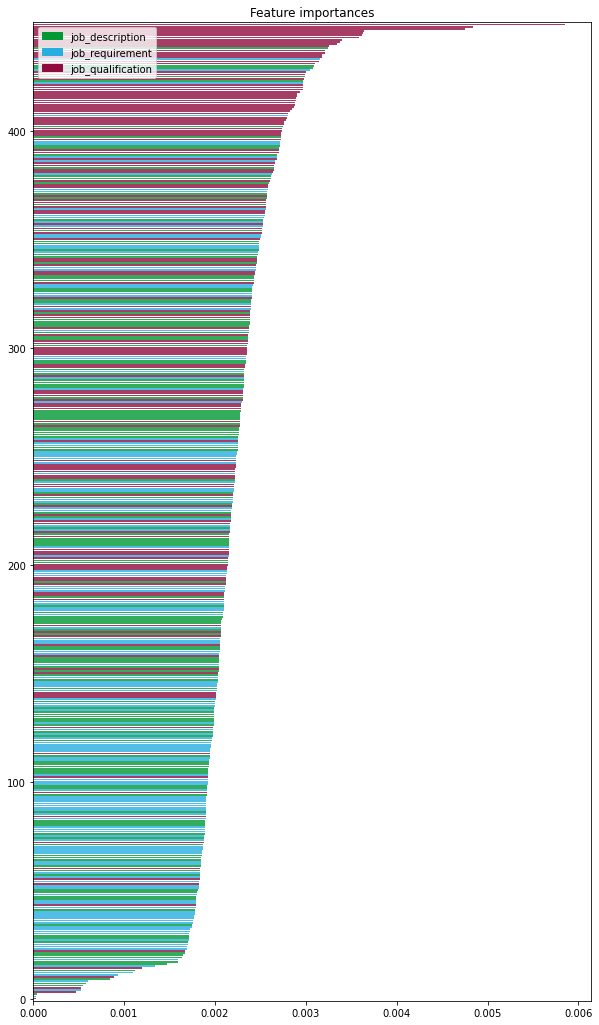

In [39]:
# Plot the feature importances of the forest
indices = np.argsort(feat_importance)

plt.figure(figsize=(10, 18))
plt.title("Feature importances")
plt.barh(
    range(X_total.shape[1]),
    feat_importance[indices],
    color=colors,
    align="center",
    alpha=0.8,
)
plt.ylim([-1, X_total.shape[1]])

green_patch = mpatches.Patch(color='#009933', label='job_description')
blue_patch = mpatches.Patch(color='#27aee1', label='job_requirement')
brown_patch = mpatches.Patch(color='#900c3f', label='job_qualification')
plt.legend(handles=[green_patch, blue_patch, brown_patch], loc="upper left")

plt.show()

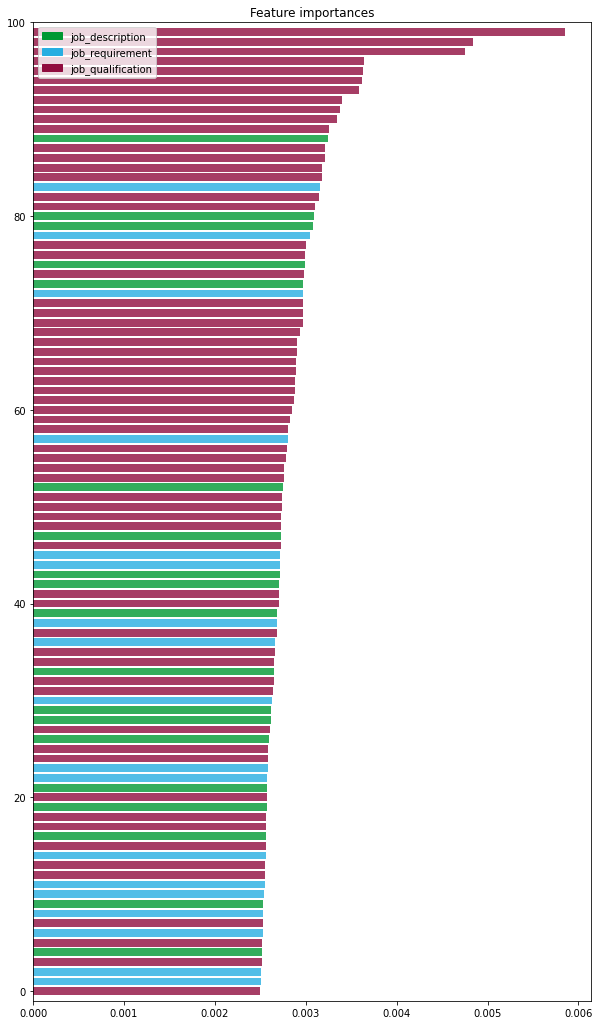

In [40]:
# Plot the feature importances of the forest
no_features = 100
plt.figure(figsize=(10, 18))
plt.title("Feature importances")
plt.barh(
    range(no_features),
    feat_importance[indices][-no_features:],
    color=colors[-no_features:],
    align="center",
    alpha=0.8,
)
plt.ylim([-1, no_features])

green_patch = mpatches.Patch(color='#009933', label='job_description')
blue_patch = mpatches.Patch(color='#27aee1', label='job_requirement')
brown_patch = mpatches.Patch(color='#900c3f', label='job_qualification')
plt.legend(handles=[green_patch, blue_patch, brown_patch], loc="upper left")

plt.show()

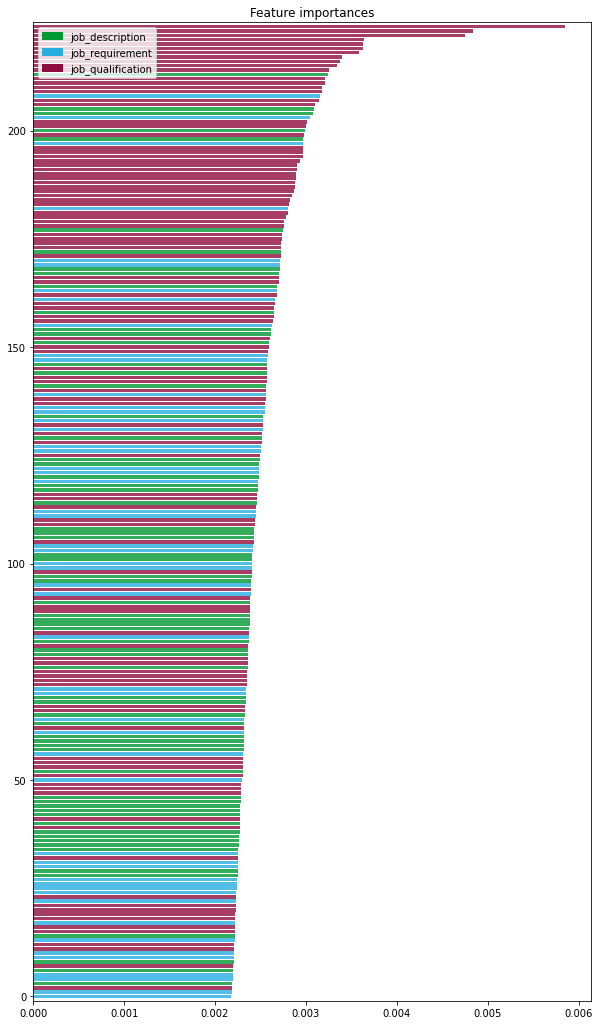

In [46]:
# Plot the feature importances of the forest
no_features = 225
plt.figure(figsize=(10, 18))
plt.title("Feature importances")
plt.barh(
    range(no_features),
    feat_importance[indices][-no_features:],
    color=colors[-no_features:],
    align="center",
    alpha=0.8,
)
plt.ylim([-1, no_features])

green_patch = mpatches.Patch(color='#009933', label='job_description')
blue_patch = mpatches.Patch(color='#27aee1', label='job_requirement')
brown_patch = mpatches.Patch(color='#900c3f', label='job_qualification')
plt.legend(handles=[green_patch, blue_patch, brown_patch], loc="upper left")

plt.show()

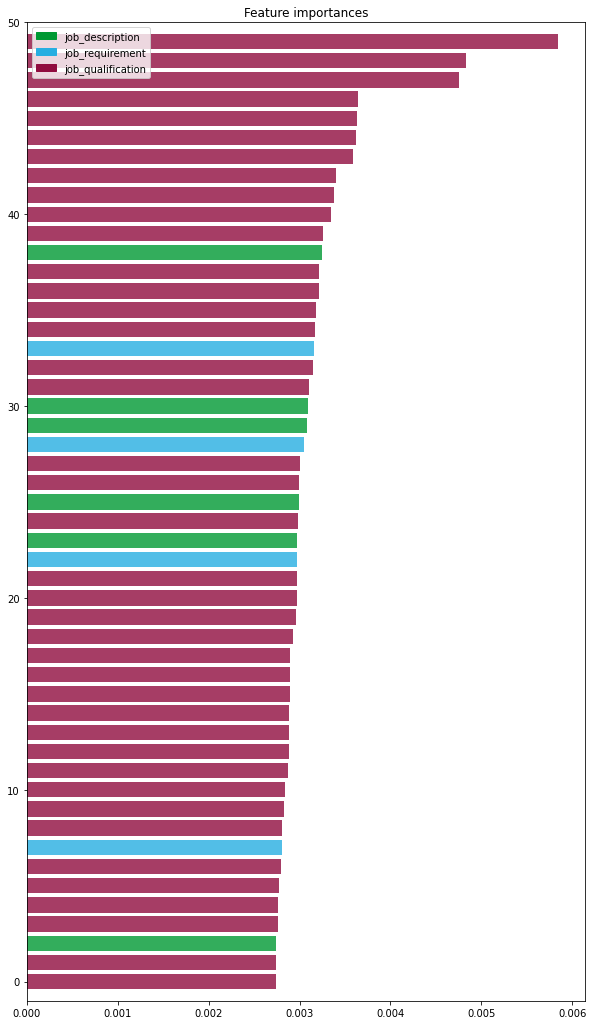

In [42]:
# Plot the feature importances of the forest
no_features = 50
plt.figure(figsize=(10, 18))
plt.title("Feature importances")
plt.barh(
    range(no_features),
    feat_importance[indices][-no_features:],
    color=colors[-no_features:],
    align="center",
    alpha=0.8,
)
plt.ylim([-1, no_features])

green_patch = mpatches.Patch(color='#009933', label='job_description')
blue_patch = mpatches.Patch(color='#27aee1', label='job_requirement')
brown_patch = mpatches.Patch(color='#900c3f', label='job_qualification')
plt.legend(handles=[green_patch, blue_patch, brown_patch], loc="upper left")

plt.show()

In [23]:
min(feat_importance), max(feat_importance), np.mean(feat_importance), np.median(feat_importance)

(3.1864635081324096e-05,
 0.005846129721643725,
 0.0022222222222222222,
 0.002180981805384163)

In [45]:
quantile = 0.50
threshold = np.quantile(feat_importance, quantile)
topn = len(feat_importance[np.where(feat_importance > threshold)[0]])
topn_features = feat_importance[indices[-topn:]]
topn_colors = colors[-topn:]
topn_description_count = len(topn_colors[np.where(topn_colors == "#009933")[0]])
topn_requirement_count = len(topn_colors[np.where(topn_colors == "#27aee1")[0]])
topn_qualification_count = len(topn_colors[np.where(topn_colors == "#900c3f")[0]])

print(
    "There are ",
    topn,
    "/",
    len(feat_importance),
    " (~",
    100 - quantile * 100,
    "%)",
    " most important features with importance higher than ",
    round(threshold, 5),
    ", including: \n - ",
    topn_description_count,
    " (~",
    round(topn_description_count * 100 / topn, 2),
    "%) features from job_description, \n - ",
    topn_requirement_count,
    " (~",
    round(topn_requirement_count * 100 / topn, 2),
    "%) features from job_requirement, \n - ",
    topn_qualification_count,
    " (~",
    round(topn_qualification_count * 100 / topn, 2),
    "%) features from job_qualification",
    sep="",
)

There are 225/450 (~50.0%) most important features with importance higher than 0.00218, including: 
 - 67 (~29.78%) features from job_description, 
 - 52 (~23.11%) features from job_requirement, 
 - 106 (~47.11%) features from job_qualification


In [47]:
# # Load document embeddings for skills from job description
# skill_description_dict = pickle.load(
#     open(OUTPUT_DIR + "skill_description_halfsize_long_dict.pkl", "rb")
# )

In [48]:
# # Load document embeddings for skills from job qualification
# skill_qualification_dict = pickle.load(
#     open(OUTPUT_DIR + "skill_qualification_halfsize_long_dict.pkl", "rb")
# )

In [49]:
# len(skill_description_dict), len(skill_qualification_dict)

In [50]:
# # Retrieve two document embeddings from dicts
# emb1 = list(skill_description_dict.values())      # job_description
# emb3 = list(skill_qualification_dict.values())    # job_qualification
# type(emb1), type(emb3), len(emb1), len(emb3), len(emb1[0]), len(emb3[0])

In [51]:
# emb1 = np.asarray(emb1)
# emb3 = np.asarray(emb3)
# emb1.shape, emb3.shape

In [52]:
# # Append two document embeddings
# skill_feat_embeddings = np.vstack((emb1, emb3))    # Omit job_requirement
# skill_feat_embeddings.shape

In [53]:
# Load document embeddings for skills from job qualification
skill_embedding_dict = pickle.load(
    open(OUTPUT_DIR + "skill_halfsize_embeddings_dict.pkl", "rb")
)

In [54]:
skill_feat_embeddings = list(skill_embedding_dict.values())
type(skill_feat_embeddings), len(skill_feat_embeddings)

(list, 257205)

In [55]:
skill_feat_embeddings = np.asarray(skill_feat_embeddings)
skill_feat_embeddings.shape

(257205, 150)

In [56]:
# Save document embeddings for skills concatenated from selected features in numpy format file
skill_feat_embeddings_outfile = OUTPUT_DIR + "skill_feat_halfsize_embeddings"
np.save(skill_feat_embeddings_outfile, skill_feat_embeddings)